## Линейная классификация

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [153]:
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [154]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Смотрим на SVM, LR

In [155]:
# Сгенерируем синтетические данные.
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

In [156]:
X.shape

(10000, 10)

✅
- Обучите метод опорных векторов.
- Подберите параметр регуляризации `C`, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR

In [157]:
def auc_pr(y_test, y_pred):
    precision, recall, th = precision_recall_curve(y_test, y_pred)
    return auc(recall, precision)

In [158]:
scl = StandardScaler()
X = scl.fit_transform(X)

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [160]:
def c_best_selection(C_set, clf, X_t, y_t, X_val, y_val):
    auc_p_r = 0
    C = 1.0

    for C_i in C_set:
        clf.C = C_i

        clf.fit(X_t, y_t)
        a_x = clf.predict(X_val)

        precision, recall, th = precision_recall_curve(y_val, a_x)

        auc_precision_recall = auc(recall, precision)

        if auc_precision_recall > auc_p_r:
            auc_p_r = auc_precision_recall
            C = C_i

    print("Подобранный параметр С:", C)
    return C


In [161]:
best_c_linearSVC = c_best_selection(np.arange(0.001, 100, 1), LinearSVC(), X_train1, y_train1, X_val,  y_val)

Подобранный параметр С: 0.001


✅ На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

### Считаем

In [293]:
clf = LinearSVC()
clf.C = best_c_linearSVC
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

In [163]:
precision, recall, th_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, th_roc = roc_curve(y_test, a_x)

In [164]:
print("AUC_ROC: %0.5f" % auc(fpr, tpr))
print("AUC_PR: %0.5f"% auc(recall, precision))

AUC_ROC: 0.77199
AUC_PR: 0.83159


In [165]:
fpr

array([0.      , 0.229265, 1.      ])

### Строим

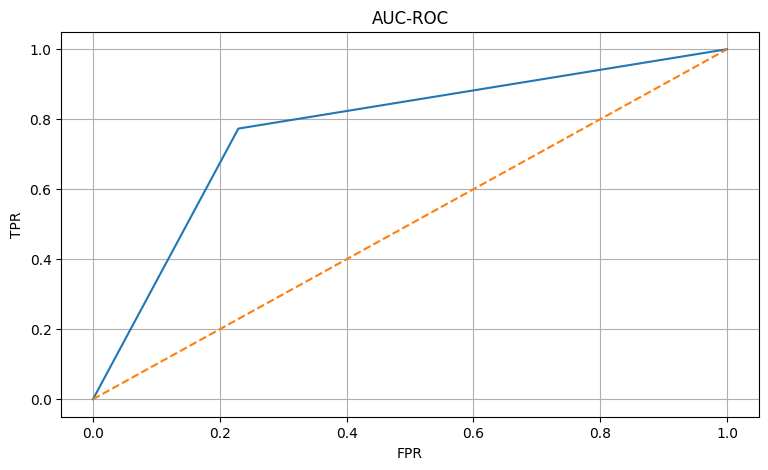

In [166]:
plt.figure(figsize=(9,5))

plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1], linestyle='--')


plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [167]:
recall

array([1.        , 0.77323665, 0.        ])

In [168]:
precision

array([0.50566667, 0.7752809 , 1.        ])

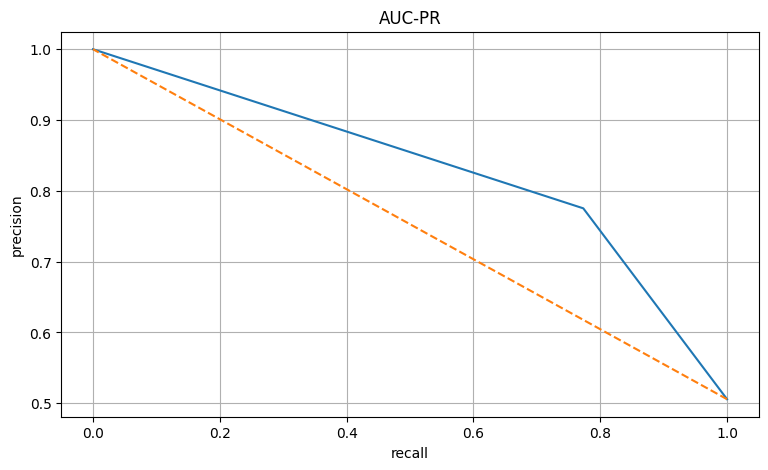

In [169]:
plt.figure(figsize=(9,5))

plt.plot(recall, precision, label="PR")
plt.plot([1, 0], [precision[0], 1], linestyle='--')

plt.grid(True)
plt.title('AUC-PR')
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

✅
- Проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых.
- Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества.

In [170]:
best_c_LR = c_best_selection(np.arange(0.001, 100, 1), LogisticRegression(), X_train1, y_train1, X_val,  y_val)

Подобранный параметр С: 1.001


In [171]:
clf = LogisticRegression()
clf.C = best_c_LR
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

precision, recall, th_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, th_roc = roc_curve(y_test, a_x)

print("AUC_ROC: %0.5f" % auc(fpr, tpr))
print("AUC_PR: %0.5f"% auc(recall, precision))

AUC_ROC: 0.77134
AUC_PR: 0.83116


### Строим

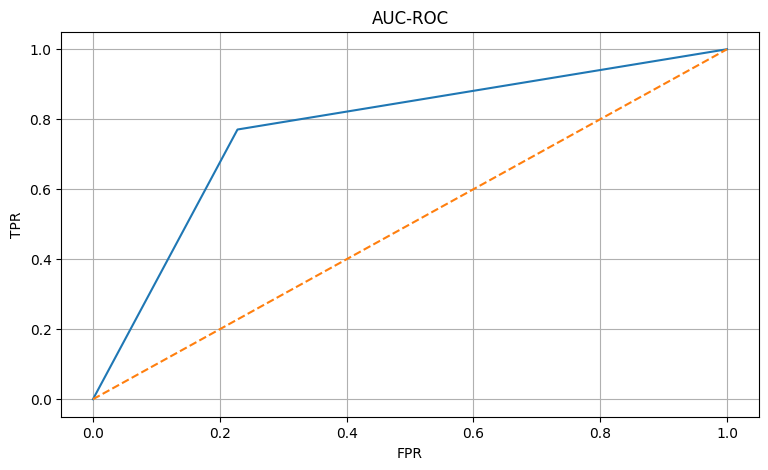

In [172]:
plt.figure(figsize=(9,5))

plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1], linestyle='--')


plt.grid(True)
plt.title('AUC-ROC')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [173]:
precision

array([0.50566667, 0.77571334, 1.        ])

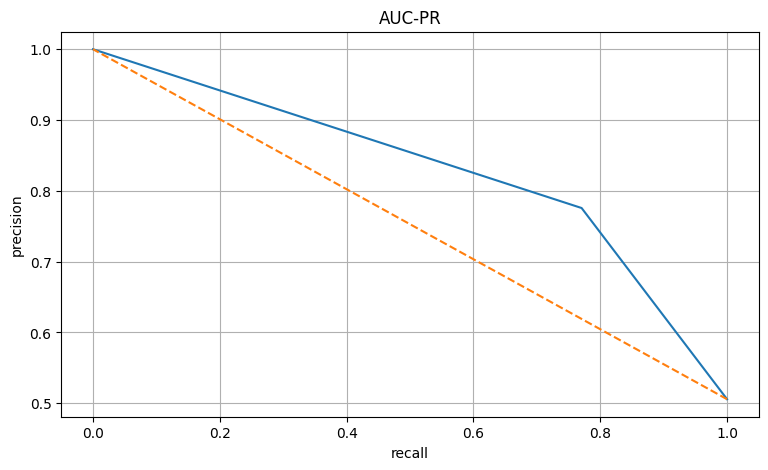

In [174]:
plt.figure(figsize=(9,5))

plt.plot(recall, precision, label="PR")
plt.plot([1, 0], [precision[0], 1], linestyle='--')

plt.grid(True)
plt.title('AUC-PR')
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

# 📌 Работаем с признаками


Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

✅ Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing)

In [175]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [176]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [177]:
df.shape

(41188, 21)

In [178]:
df.isna().any().any()

False

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

✅
 - Разделите выборку на обучающую и тестовую в соотношении 3:1.
 - Зафиксируйте `random_state=777`, используйте `stratify`.
 - Удалите столбец, который не несет информации для решения задачи.



In [180]:
df["y"].unique()

array(['no', 'yes'], dtype=object)

In [181]:
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1

In [182]:
df.shape

(41188, 21)

In [183]:
df['y'].fillna(df['y'].median())

,y
0,1
1,1
2,1
3,1
4,1
...,...
41183,0
41184,1
41185,1
41186,0


✅
- Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

- Почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

**Разделим признаки на категориальные и вещественные**

In [184]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['duration', 'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

### Подготовка к обучению модели

In [185]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [186]:
#для кодирования категориальных признаков используем OrdinalEncoder
enc = OrdinalEncoder()

In [187]:
#вещественные признаки также отмасштабируем
data = ColumnTransformer([
                     ('cat', enc, cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

### Переходим к обучению

In [188]:
df_ = pd.DataFrame({'name': ['n', 'n', 'v', 'm', 'v', 'n']})

In [189]:
df_

,name
0,n
1,n
2,v
3,m
4,v
5,n


In [190]:
enc.fit_transform(df_)

array([[1.],
       [1.],
       [2.],
       [0.],
       [2.],
       [1.]])

In [191]:
df = df.dropna()

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'),
                                    df['y'], test_size = 0.3,
                                    random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [192]:
start_time = time.time()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение OrdinalEncoder:', time.time()-start_time)
print('AUC-PR на OrdinalEncoder = %.5f' % auc_pr(y_test,y_pred))
print('Кол-во столбцов', data.fit_transform(X_train).shape[1])

Время на обучение OrdinalEncoder: 0.4746251106262207
AUC-PR на OrdinalEncoder = 0.96217
Кол-во столбцов 20


In [193]:
model

Pipeline(steps=[('enc_and_st_scaler',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome']),
                                                 ('num', StandardScaler(),
                                                  ['duration', 'age',
                                                   'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.conf.idx',
                                                   'cons.price.idx',
                                                   'euribor3m',
                                                   'nr.employed'])])),
                ('classifier', LogisticRegression())])

✅
- Закодируйте все категориальные признаки с помощью one-hot-кодирования.
- Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования).
- Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [194]:
#для кодирования категориальных признаков используем OneHotEncoder
enc = OneHotEncoder(handle_unknown="ignore")

#вещественные признаки также отмасштабируем
data = ColumnTransformer([
                     ('cat', enc, cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

In [195]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='y'),
                                    df['y'], test_size = 0.3,
                                    random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [196]:
start_time = time.time()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение OHE:', time.time()-start_time)
print('AUC-PR на OHE = %.5f' % auc_pr(y_test,y_pred))
print('Кол-во столбцов', data.fit_transform(X_train).shape[1])

Время на обучение OHE: 0.4922051429748535
AUC-PR на OHE = 0.96287
Кол-во столбцов 63


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории. Метод предполагает кодирование категорий средним арифметическим от суммы целевых меток
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$



✅
- Закодируйте категориальные переменные с помощью счётчиков:

$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

- Обучите логистическую регрессию и посмотрите на качество модели на тестовой выборке.
- Сравните с предыдущими экспериментами

In [197]:
#вещественные признаки также отмасштабируем, категориальные отмасштабируем отдельно
data = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

### Кодирование категориальных, обучение модели и тестирование

In [198]:
start_time = time.time()

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_train = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0] / X_train[X_train[col] == categ].shape[0]
        X_train.loc[X_train[col] == categ, col] = g_train


        g_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0] / X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_test

#обучение, тестировние
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding = %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', X_train.shape[1])

Время на обучение модели: 1.1343433856964111
AUC-PR при mean-target encoding = 0.96173
Кол-во столбцов  20


✅
- Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям .
- Снова обучите логистическую регрессию, оцените качество.
- Сделайте выводы.


In [199]:
start_time = time.time()
for col in cat:
    #добавим шума к категориальным признакам
    X_train[col] += np.random.rand(X_train.shape[0]) * np.sign(np.random.rand(X_train.shape[0]) - 0.5) / 10
    X_test[col] += np.random.rand(X_test.shape[0]) * np.sign(np.random.rand(X_test.shape[0]) - 0.5) / 10

clf = LogisticRegression()
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding и шуме= %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', X_train.shape[1])

Время на обучение модели: 0.476118803024292
AUC-PR при mean-target encoding и шуме= 0.96174
Кол-во столбцов  20


✅ Добавьте сглаживание, а затем повторите эксперименты.

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$

In [200]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'),
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [201]:
#вещественные признаки также отмасштабируем, категориальные отмасштабируем отдельно
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', date),
                   ('classifier', LogisticRegression())
                   ])

In [202]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса (global_mean)
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса (global_mean)
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test

model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 1.1958258152008057
AUC-PR при global mean = 0.96451


✅ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [203]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'),
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [204]:
print('Кол-во уникальных возрастов', df['age'].nunique())

Кол-во уникальных возрастов 78


In [205]:
#теперь возраст категориальная переменная
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed', 'duration']

In [206]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test

model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 1.4020216464996338
AUC-PR при global mean = 0.97287


**Заметим, что AUC_PR стала выше**

**Домашнее задание**

✅ Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [207]:
X = df

#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns = 'y'),
                                                    X['y'], test_size=0.3, random_state=777, stratify = X['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [208]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [209]:
cat = ['job', 'marital', 'education', 'default', 'housing', 'month', 'day_of_week',
            'loan', 'contact', 'poutcome']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate', 'age',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [210]:
#вещественные признаки также отмасштабируем, категориальные отмасштабируем отдельно
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', date),
                   ('classifier', LogisticRegression())
                   ])

In [211]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test

model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 1.3640713691711426
AUC-PR при global mean = 0.95536


**AUC-PR стал хуже**

# 📌 Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [212]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify = y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [213]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1


✅ В данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

### Вспомним как были разделены признаки (на вещественные и категориальные)

In [214]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed', 'duration']

### Закодируем категориальрные признаки с помощью one-hot кодирования

**Будем использовать метод get_dummies**

In [215]:
#для красивого вывода названий столбцов
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(X_train, columns = cat_mask, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask, drop_first=True)

In [216]:
X_train.shape

(28831, 52)

✅ В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке.

In [217]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

auc_pr_lr_ohe = auc_pr(y_test, a_x)

In [218]:
print("AUC_PR = %.5f" % auc_pr_lr_ohe)

AUC_PR = 0.95217


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.





✅
 - Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество?

In [219]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

x_train = X_train.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test, a_x)

print('Время обучения модели', time.time()-start_time)
print("AUC_PR = %.5f" % auc_pr_lr_fourty)

Время обучения модели 0.8675699234008789
AUC_PR = 0.95237


In [220]:
indices

Index([44, 48, 51, 37, 29, 45, 38, 17, 18, 33, 14,  0, 22, 11, 26, 31, 12, 19,
        2, 23, 32, 34, 10, 27,  8, 35, 25,  1, 43, 15, 24, 20, 46,  3, 30,  9,
       36, 42,  4,  7],
      dtype='int64')

### Отмасшабируем признаки с помощью StandartScaler и OHE

**Снова разделим данные**

In [221]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

### Кодирование

In [222]:
#вещественные признаки отмасштабируем с помощью StandardScaler, категориальные пока не трогаем
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])

X_train = pd.DataFrame(date.fit_transform(X_train))
X_test = pd.DataFrame(date.transform(X_test))

In [223]:
#кодируем категориальные признаки
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(data=X_train, columns=X_train.iloc[:, 0:10].columns, drop_first=True)
X_test = pd.get_dummies(data=X_test, columns=X_test.iloc[:, 0:10].columns, drop_first=True)

In [224]:
X_train

,10,11,12,13,14,15,16,17,18,19,0_blue-collar,0_entrepreneur,0_housemaid,0_management,0_retired,0_self-employed,0_services,0_student,0_technician,0_unemployed,0_unknown,1_married,1_single,1_unknown,2_basic.6y,2_basic.9y,2_high.school,2_illiterate,2_professional.course,2_university.degree,2_unknown,3_unknown,3_yes,4_unknown,4_yes,5_unknown,5_yes,6_telephone,7_aug,7_dec,7_jul,7_jun,7_mar,7_may,7_nov,7_oct,7_sep,8_mon,8_thu,8_tue,8_wed,9_nonexistent,9_success
0,-0.289536,-0.567466,0.196418,-0.351015,-2.213588,2.249459,-1.599578,-1.669748,-2.061837,-0.035962,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False
1,-0.958139,-0.567466,0.196418,1.665344,-1.131825,0.477886,0.781528,-1.563255,-2.419431,-0.392675,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,1.62076,-0.203565,0.196418,-0.351015,-0.113695,-0.321482,-0.647481,0.233315,0.399899,-0.477976,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
3,0.570097,-0.567466,0.196418,1.665344,-1.195458,-1.228873,-1.17796,-1.352571,-0.93521,-0.291865,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
4,1.42973,-0.203565,0.196418,-0.351015,0.840802,-0.278273,1.538367,0.719154,0.845855,1.247428,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,1.42973,-0.203565,0.196418,-0.351015,0.840802,-0.278273,1.538367,0.718579,0.845855,-0.160036,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False
28827,-0.76711,-0.567466,0.196418,-0.351015,0.840802,0.953186,-0.225863,0.778445,0.845855,0.130762,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
28828,-0.480565,0.160335,0.196418,-0.351015,0.840802,-0.472714,0.593182,0.774991,0.845855,-0.29962,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False
28829,0.761127,-0.567466,0.196418,-0.351015,-1.195458,-1.228873,-1.17796,-1.313427,-0.93521,-0.536136,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False


**Теперь выберем 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модель, оценим её качество.**

In [225]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [226]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [227]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(53)]).sort_values(by=0).tail(40).index #Выбрали 40 лучших весов

x_train = X_train.iloc[:, indices.values] #выбрали признаки, соответствующие лучшим весам
x_test = X_test.iloc[:, indices.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test,a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR (40 признаков) = %.5f" %  auc_pr_lr_fourty)
print('indices =', indices)

Время на обучение модели: 0.31069421768188477
AUC-PR (40 признаков) = 0.95300
indices = Index([49, 46, 22, 29, 12, 30, 23, 48,  5, 19,  8, 21,  0, 18, 40, 25, 26, 34,
       28, 32, 13, 20,  3, 36, 11, 33, 35, 45,  1, 15, 16,  2, 47, 10, 31, 41,
       44, 43, 37,  4],
      dtype='int64')


**Домашнее задание**

✅ one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [228]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [229]:
cat_mask = X_train.select_dtypes(include=[object]).columns
cat_mask = X_test.select_dtypes(include=[object]).columns

X_train = pd.get_dummies(X_train, columns = cat_mask, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask, drop_first=True)

In [230]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [231]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
ax = log_reg.predict(X_test)

indices = pd.DataFrame(log_reg.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

indices

Index([20, 48,  0, 13, 38, 16, 22, 29, 45, 28, 26, 18, 17, 11, 24, 10, 12, 33,
       14, 32, 34, 39, 25, 35, 44, 19,  3, 15, 27, 46,  9, 31,  1, 30, 43,  2,
       40, 42, 36,  4],
      dtype='int64')

In [232]:
print(f'Значение AUC-PR для отскалированных признаков после ohe: {auc_pr(y_test, ax) }')

Значение AUC-PR для отскалированных признаков после ohe: 0.953605377866302


**Домашнее задание**

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.




✅ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.

In [233]:
from math import sqrt

In [234]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('bank-additional-full.csv', sep=';')

df[df['y'] == 'yes'] = 1
df[df['y'] == 'no'] = 0

X_train, X_test, y_train, y_test = train_test_split(df.drop(['y'], axis = 1), df['y'], test_size=0.3, random_state=777, stratify=df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

cat_mask = X_train.select_dtypes(include=[object]).columns
cat_mask = X_test.select_dtypes(include=[object]).columns

for col in cat_mask:
    X_train[col] = LabelEncoder().fit_transform(X_train[col])
    X_test[col] = LabelEncoder().fit_transform(X_test[col])

In [235]:
def select_important_features(df, n_features=40):
    class_0 = df[df['y'] == 0]
    class_1 = df[df['y'] == 1]

    t_statistics = {}
    for column in df.drop(columns='y').columns:
        u = abs(class_1[column].mean() - class_0[column].mean())
        denominator = np.sqrt((class_1[column].shape[0] * (np.std(class_1[column]) ** 2) +
                               class_0[column].shape[0] * (np.std(class_0[column]) ** 2)) /
                              (class_1[column].shape[0] + class_0[column].shape[0]))

        t_stat = u / denominator
        t_statistics[column] = t_stat

    sorted_features = sorted(t_statistics, key=t_statistics.get, reverse=True)
    important_features = sorted_features[:n_features]

    return important_features

In [236]:
def evaluate_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return auc_pr(y_test, y_pred)

In [237]:
start_time_all = time.time()
auc_pr_all = evaluate_model(X_train, X_test, y_train, y_test)
end_time_all = time.time()

print(f"Качество модели на всех признаках:")
print(f"AUC PR: {auc_pr_all}")
print(f"Время выполнения: {end_time_all - start_time_all} секунд")

important_features = select_important_features(df)

X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

start_time_filtered = time.time()
auc_pr_filtered = evaluate_model(X_train_filtered, X_test_filtered, y_train, y_test)
end_time_filtered = time.time()

print(f"\nКачество модели на отобранных признаках:")
print(f"PR AUC: {auc_pr_filtered}")
print(f"Время выполнения: {end_time_filtered - start_time_filtered} секунд")

Качество модели на всех признаках:
AUC PR: 1.0
Время выполнения: 0.04907870292663574 секунд


<ipython-input-235-2334002681fe>:12: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = u / denominator



Качество модели на отобранных признаках:
PR AUC: 1.0
Время выполнения: 0.04747605323791504 секунд


**Домашнее задание**

### Методы-обёртки


Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).


✅ Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [238]:
#ПОДГРУЗКА ДАННЫХ
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#ПРЕОБРАЗОВАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ
y_train = y_train.astype('int')
y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')

#КОДИРОВАНИЕ ДАННЫХ
#закодировали категории
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask1 = X_train1.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
cat_mask3 = X_val.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(X_train, columns = cat_mask, drop_first=True)
X_train1 = pd.get_dummies(X_train1, columns = cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask2, drop_first=True)
X_val = pd.get_dummies(X_val, columns = cat_mask3, drop_first=True)
columns_ = X_train1.columns

#отмасштабируем все!
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_train1 = pd.DataFrame(scaler.fit_transform(X_train1))
X_test = pd.DataFrame(scaler.transform(X_test))
X_val = pd.DataFrame(scaler.transform(X_val))

X_train.columns = columns_
X_train1.columns = columns_
X_test.columns = columns_
X_val.columns = columns_

In [239]:
X_train1.columns = columns_

### Начинаем отбор

In [240]:
def quality_assessment(X_train, y_train, X_test, y_test):
    log_reg = LogisticRegression(max_iter = 10000)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    return auc(recall, precision)

In [241]:
X_train.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,0.955475,-0.570952,0.193869,-0.350094,0.647305,0.719420,0.887039,0.711733,0.330697,1.851707,-0.18988,-0.16347,-0.274667,-0.207657,-0.190246,-0.328329,-0.149915,-0.438874,-0.157204,-0.090327,0.811857,-0.628545,-0.042616,-0.242673,-0.412018,-0.549336,-0.020519,-0.381237,-0.647985,-0.211779,1.954852,-0.008047,6.288034,-1.049081,6.288034,-0.422872,1.318822,-0.420476,-0.066744,-0.460622,-0.386565,-0.11811,1.420728,-0.333447,-0.134887,-0.118672,-0.50928,-0.514619,2.021123,-0.495839,0.397392,-0.184226
1,-1.341636,0.520847,0.193869,-0.350094,0.647305,0.719420,0.887039,0.710580,0.330697,1.851707,-0.18988,-0.16347,-0.274667,-0.207657,-0.190246,-0.328329,-0.149915,-0.438874,-0.157204,-0.090327,-1.231744,1.590977,-0.042616,-0.242673,-0.412018,1.820380,-0.020519,-0.381237,-0.647985,-0.211779,-0.511548,-0.008047,-0.159032,-1.049081,-0.159032,-0.422872,1.318822,-0.420476,-0.066744,-0.460622,-0.386565,-0.11811,1.420728,-0.333447,-0.134887,-0.118672,-0.50928,-0.514619,-0.494774,-0.495839,0.397392,-0.184226
2,-0.575932,0.156914,0.193869,-0.350094,0.838301,-0.229963,0.951837,0.773427,0.842704,-0.540042,-0.18988,-0.16347,-0.274667,-0.207657,-0.190246,-0.328329,-0.149915,2.278557,-0.157204,-0.090327,0.811857,-0.628545,-0.042616,-0.242673,-0.412018,1.820380,-0.020519,-0.381237,-0.647985,-0.211779,-0.511548,-0.008047,-0.159032,0.953215,-0.159032,-0.422872,-0.758252,2.378257,-0.066744,-0.460622,-0.386565,-0.11811,-0.703865,-0.333447,-0.134887,-0.118672,-0.50928,1.943187,-0.494774,-0.495839,0.397392,-0.184226
3,-0.958784,-0.570952,0.193869,-0.350094,0.647305,0.719420,0.887039,0.710580,0.330697,1.851707,-0.18988,-0.16347,-0.274667,-0.207657,-0.190246,-0.328329,-0.149915,-0.438874,-0.157204,-0.090327,-1.231744,1.590977,-0.042616,-0.242673,2.427076,-0.549336,-0.020519,-0.381237,-0.647985,-0.211779,-0.511548,-0.008047,-0.159032,0.953215,-0.159032,-0.422872,1.318822,-0.420476,-0.066744,-0.460622,-0.386565,-0.11811,1.420728,-0.333447,-0.134887,-0.118672,-0.50928,-0.514619,-0.494774,-0.495839,0.397392,-0.184226
4,-1.054497,-0.207019,0.193869,-0.350094,-0.116675,-0.651144,-0.322526,0.261424,0.396941,-0.540042,-0.18988,-0.16347,-0.274667,-0.207657,-0.190246,-0.328329,-0.149915,-0.438874,-0.157204,-0.090327,-1.231744,1.590977,-0.042616,-0.242673,-0.412018,-0.549336,-0.020519,-0.381237,1.543246,-0.211779,-0.511548,-0.008047,-0.159032,0.953215,-0.159032,-0.422872,-0.758252,-0.420476,-0.066744,-0.460622,-0.386565,-0.11811,-0.703865,2.998975,-0.134887,-0.118672,-0.50928,1.943187,-0.494774,-0.495839,0.397392,-0.184226


In [242]:
X_test.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,1.629014,-0.577466,0.191899,1.697402,-1.203602,-1.184612,-1.229275,-1.342978,-0.942274,-0.539947,-0.189687,-0.167485,-0.273609,-0.205604,-0.188769,-0.329009,-0.148736,2.287228,-0.159127,-0.089545,0.811142,-0.624436,-0.043586,-0.241542,-0.41363,1.812271,-0.023564,-0.380527,-0.643003,-0.213185,-0.511565,-0.006801,-0.160344,-1.053748,-0.160344,2.356358,-0.756465,-0.41944,-0.066429,-0.460786,-0.386873,-0.11557,1.416965,-0.336127,-0.131399,-0.11781,1.956160,-0.510990,-0.495689,-0.499234,-2.499749,-0.183315
1,1.437022,-0.205455,0.191899,-0.354072,0.646970,0.720488,0.895622,0.712865,0.328695,-0.539947,-0.189687,-0.167485,-0.273609,-0.205604,-0.188769,-0.329009,-0.148736,-0.437210,-0.159127,11.167592,0.811142,-0.624436,-0.043586,-0.241542,-0.41363,-0.551794,-0.023564,-0.380527,-0.643003,4.690756,1.954784,-0.006801,-0.160344,0.948994,-0.160344,-0.424384,1.321939,-0.41944,-0.066429,-0.460786,-0.386873,-0.11557,1.416965,-0.336127,-0.131399,-0.11781,-0.511206,1.956987,-0.495689,-0.499234,0.400040,-0.183315
2,-0.674888,-0.577466,0.191899,1.697402,-1.203602,-1.184612,-1.229275,-1.334895,-0.942274,1.852035,-0.189687,-0.167485,-0.273609,-0.205604,-0.188769,-0.329009,-0.148736,-0.437210,-0.159127,-0.089545,0.811142,-0.624436,-0.043586,-0.241542,2.41762,-0.551794,-0.023564,-0.380527,-0.643003,-0.213185,-0.511565,-0.006801,-0.160344,-1.053748,-0.160344,-0.424384,-0.756465,-0.41944,-0.066429,-0.460786,-0.386873,-0.11557,1.416965,-0.336127,-0.131399,-0.11781,-0.511206,-0.510990,-0.495689,-0.499234,-2.499749,-0.183315
3,-0.386900,0.538566,0.191899,-0.354072,0.838409,1.535476,-0.275240,0.774638,0.841784,-0.539947,-0.189687,-0.167485,-0.273609,-0.205604,-0.188769,-0.329009,-0.148736,-0.437210,-0.159127,-0.089545,0.811142,-0.624436,-0.043586,-0.241542,-0.41363,1.812271,-0.023564,-0.380527,-0.643003,-0.213185,-0.511565,-0.006801,-0.160344,-1.053748,-0.160344,-0.424384,1.321939,-0.41944,-0.066429,-0.460786,2.584831,-0.11557,-0.705734,-0.336127,-0.131399,-0.11781,-0.511206,-0.510990,-0.495689,-0.499234,0.400040,-0.183315
4,-1.250864,-0.205455,0.191899,-0.354072,0.838409,0.588982,-0.470383,0.772329,0.841784,-0.539947,-0.189687,5.970691,-0.273609,-0.205604,-0.188769,-0.329009,-0.148736,-0.437210,-0.159127,-0.089545,0.811142,-0.624436,-0.043586,-0.241542,-0.41363,1.812271,-0.023564,-0.380527,-0.643003,-0.213185,-0.511565,-0.006801,-0.160344,0.948994,-0.160344,-0.424384,-0.756465,-0.41944,-0.066429,2.170207,-0.386873,-0.11557,-0.705734,-0.336127,-0.131399,-0.11781,-0.511206,-0.510990,-0.495689,-0.499234,0.400040,-0.183315


In [243]:
import time

# Оценка начального качества на всех признаках
start_time = time.time()

initial_quality = quality_assessment(X_train, y_train, X_test, y_test)
print(f"Начальное качество модели (все признаки): {initial_quality}")

# Инициализация
quality = {}

# Жадный отбор признаков
for col in X_train.columns:
    # Останавливаемся, если количество признаков <= 40
    if X_train.shape[1] > 40:
        X_test = X_test.drop(columns = [col])  # Удаляем один признак
        X_train = X_train.drop(columns = [col])

        current_quality = quality_assessment(X_train, y_train, X_test, y_test)  # Оценка качества
        quality[col] = current_quality  # Сохраняем качество после удаления признака

        # Вывод информации о текущем шаге
        print(f"Удален признак: {col}")
        print(f"Качество модели после удаления {col}: {current_quality}")
        print(f"Осталось признаков: {X_train.shape[1]}")
    else:
        break

end_time = time.time()

# Итоговые результаты
print("\nВремя выполнения:", end_time - start_time)
print("Качество после удаления каждого признака:", quality)

Начальное качество модели (все признаки): 0.9534728835198139
Удален признак: age
Качество модели после удаления age: 0.9535308659098924
Осталось признаков: 51
Удален признак: campaign
Качество модели после удаления campaign: 0.9535121180423438
Осталось признаков: 50
Удален признак: pdays
Качество модели после удаления pdays: 0.9534956948663416
Осталось признаков: 49
Удален признак: previous
Качество модели после удаления previous: 0.9534564668973103
Осталось признаков: 48
Удален признак: emp.var.rate
Качество модели после удаления emp.var.rate: 0.9539153251175078
Осталось признаков: 47
Удален признак: cons.price.idx
Качество модели после удаления cons.price.idx: 0.9537784924977368
Осталось признаков: 46
Удален признак: cons.conf.idx
Качество модели после удаления cons.conf.idx: 0.9539955594151919
Осталось признаков: 45
Удален признак: euribor3m
Качество модели после удаления euribor3m: 0.9539938412804287
Осталось признаков: 44
Удален признак: nr.employed
Качество модели после удаления 

✅ Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте добавлять по одному самому полезному признаку в выборку до тех пор, пока не наберется 20 штук.

In [288]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

df['y'] = df['y'].map({'yes': 1, 'no': 0})

X_train, X_test, y_train, y_test = train_test_split(df.drop(['y'], axis=1), df['y'], test_size=0.3, random_state=777, stratify=df['y'])

y_train = y_train.astype(int)
y_test = y_test.astype(int)

cat_mask = X_train.select_dtypes(include=[object]).columns

for col in cat_mask:
    X_train[col] = LabelEncoder().fit_transform(X_train[col])
    X_test[col] = LabelEncoder().fit_transform(X_test[col])

In [289]:
def select_important_features(df, n_features=40):
    class_0 = df[df['y'] == 0]
    class_1 = df[df['y'] == 1]

    t_statistics = {}
    for column in df.drop(columns='y').columns:
        u = abs(class_1[column].mean() - class_0[column].mean())
        denominator = np.sqrt((class_1[column].shape[0] * (np.std(class_1[column]) ** 2) +
                               class_0[column].shape[0] * (np.std(class_0[column]) ** 2)) /
                              (class_1[column].shape[0] + class_0[column].shape[0]))

        t_stat = u / denominator
        t_statistics[column] = t_stat

    sorted_features = sorted(t_statistics, key=t_statistics.get, reverse=True)
    important_features = sorted_features[:n_features]

    return important_features

def quality_assessment(X_train, y_train, X_test, y_test):
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    return auc(recall, precision)

In [291]:
important_features = select_important_features(pd.concat([X_train, y_train], axis=1))

X_train_3 = pd.DataFrame()
X_test_3 = pd.DataFrame()

for idx, col in enumerate(important_features[:20]):
    X_train_3[col] = X_train[col]
    X_test_3[col] = X_test[col]

    current_quality = quality_assessment(X_train_3, y_train, X_test_3, y_test)
    print(f"Качество модели с {idx + 1} признаками ({col}): AUC PR = {current_quality}")

Качество модели с 1 признаками (duration): AUC PR = 0.3826558669288368
Качество модели с 2 признаками (nr.employed): AUC PR = 0.5124679249353368
Качество модели с 3 признаками (pdays): AUC PR = 0.5459314174939853
Качество модели с 4 признаками (euribor3m): AUC PR = 0.5450971777530385
Качество модели с 5 признаками (emp.var.rate): AUC PR = 0.5460929937720563
Качество модели с 6 признаками (previous): AUC PR = 0.5478270118491648
Качество модели с 7 признаками (contact): AUC PR = 0.5510134010608118
Качество модели с 8 признаками (cons.price.idx): AUC PR = 0.5520196358163679
Качество модели с 9 признаками (poutcome): AUC PR = 0.5540980178678941
Качество модели с 10 признаками (default): AUC PR = 0.5557472957429871
Качество модели с 11 признаками (campaign): AUC PR = 0.5559803319424265
Качество модели с 12 признаками (cons.conf.idx): AUC PR = 0.5570241652064062
Качество модели с 13 признаками (education): AUC PR = 0.5571567812045928
Качество модели с 14 признаками (marital): AUC PR = 0.5571